c:\Users\Ruy\anaconda3\Lib\site-packages\tqdm_joblib\__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Dimensões do dataframe: (4981, 11)
   gender   age  hypertension  heart_disease ever_married      work_type  \
0    Male  67.0             0              1          Yes        Private   
1    Male  80.0             0              1          Yes        Private   
2  Female  49.0             0              0          Yes        Private   
3  Female  79.0             1              0          Yes  Self-employed   
4    Male  81.0             0              0          Yes        Private   

  Residence_type  avg_glucose_level   bmi   smoking_status  stroke  
0          Urban             228.69  36.6  formerly smoked       1  
1          Rural             105.92  32.5     never smoked       1  
2          Urban             171.23  34.4           smokes       1  
3          Rural             174.12  24.0     never smoked       1  
4          Urban             186.21  29.0  formerly smoked       1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4981 entries, 0 to 4980
Data columns (total 

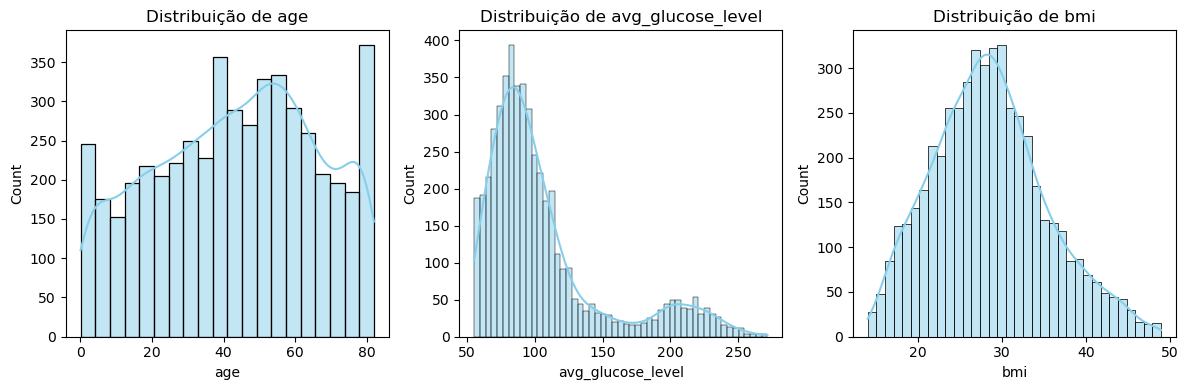

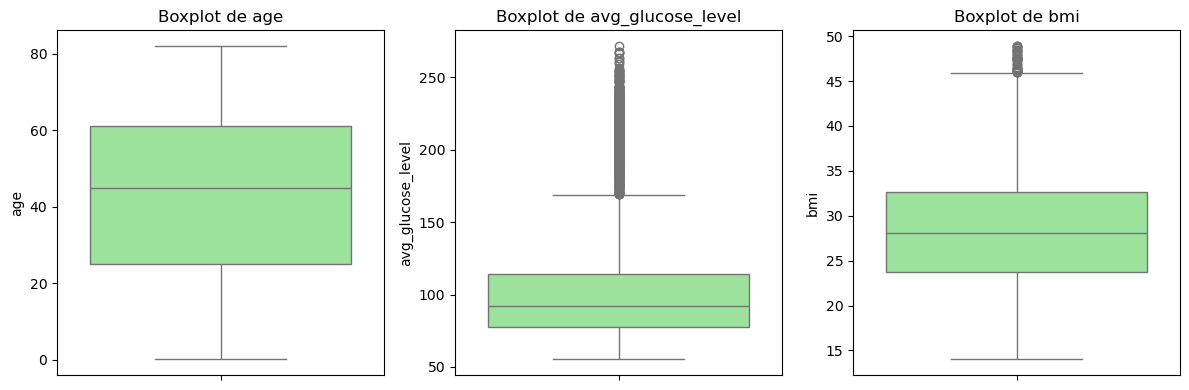

Distribuição original da variável alvo:
stroke
0    4733
1     248
Name: count, dtype: int64


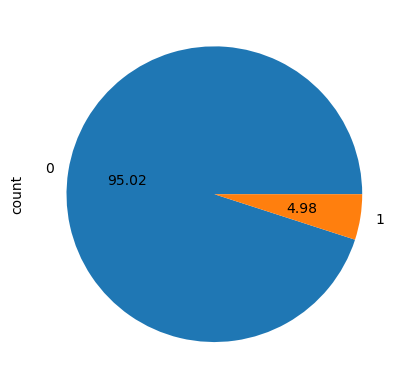

Distribuição balanceada da variável alvo:
stroke
0    4733
1    4733
Name: count, dtype: int64


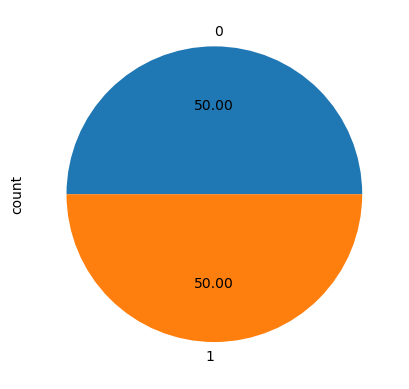

Total de iterações estimadas: 60


GridSearchCV:   0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Melhores hiperparâmetros: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Melhor acurácia: 0.9808505870402101

Relatório de Classificação:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98       951
           1       0.97      1.00      0.98       943

    accuracy                           0.98      1894
   macro avg       0.98      0.98      0.98      1894
weighted avg       0.98      0.98      0.98      1894


Matriz de Confusão:
 [[918  33]
 [  0 943]]
Shape das predições de probabilidade: (1894, 2)


In [1]:
# 1. Instalação (se necessário) e importação das bibliotecas
# Caso ainda não tenha instalado, descomente as linhas abaixo:
# !pip install imbalanced-learn
# !pip install tqdm
# !pip install tqdm_joblib

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

# Importando as bibliotecas para paralelização e progress bar
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib
import joblib

# 2. Carregando o dataset
df = pd.read_csv('full_data.csv')
print("Dimensões do dataframe:", df.shape)
print(df.head())
df.info()

# 3. Análise Exploratória
num_cols = ['age', 'avg_glucose_level', 'bmi']

plt.figure(figsize=(12, 4))
for i, col in enumerate(num_cols):
    plt.subplot(1, 3, i+1)
    sns.histplot(data=df, x=col, kde=True, color='skyblue')
    plt.title(f"Distribuição de {col}")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
for i, col in enumerate(num_cols):
    plt.subplot(1, 3, i+1)
    sns.boxplot(y=df[col], color='lightgreen')
    plt.title(f"Boxplot de {col}")
plt.tight_layout()
plt.show()

# 4. One-Hot-Encoding das variáveis categóricas
cat_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
df = pd.get_dummies(df, columns=cat_cols).astype(int)

# Removendo a coluna 'id', se existir
if 'id' in df.columns:
    df.drop('id', axis=1, inplace=True)

# 5. Separação de variáveis preditoras (X) e alvo (y)
X = df.drop('stroke', axis=1)
y = df['stroke']

print("Distribuição original da variável alvo:")
print(y.value_counts())
y.value_counts().plot.pie(autopct='%.2f')
plt.show()

# 6. Balanceamento de classes: Oversampling + Undersampling
under = RandomUnderSampler()
over = RandomOverSampler()

pipeline = Pipeline(steps=[('o', over), ('u', under)])
X, y = pipeline.fit_resample(X, y)

print("Distribuição balanceada da variável alvo:")
print(y.value_counts())
y.value_counts().plot.pie(autopct='%.2f')
plt.show()

# 7. Divisão dos dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 8. Configuração do Grid Search para otimizar o SVM
svm_model = SVC(probability=True)

# Definindo o grid de hiperparâmetros
param_grid = {
    'kernel': ['rbf', 'linear'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}

# Configurando o GridSearchCV com validação cruzada de 5 folds e paralelização (n_jobs=-1)
grid_search = GridSearchCV(
    estimator=svm_model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=0  # O tqdm exibirá o progresso, então podemos deixar verbose=0
)

# Calculando o total de iterações: número de combinações * número de folds
total_iter = grid_search.cv * np.prod([len(v) for v in param_grid.values()])
print(f"Total de iterações estimadas: {total_iter}")

# 9. Realizando o Grid Search com tqdm_joblib para monitorar o progresso
with tqdm_joblib(tqdm(desc="GridSearchCV", total=total_iter)) as progress_bar:
    grid_search.fit(X_train, y_train)

print("Melhores hiperparâmetros:", grid_search.best_params_)
print("Melhor acurácia:", grid_search.best_score_)

# 10. Avaliação do modelo com os melhores hiperparâmetros
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))
print("\nMatriz de Confusão:\n", confusion_matrix(y_test, y_pred))

# Caso deseje obter as probabilidades das predições
y_pred_proba = best_model.predict_proba(X_test)
print("Shape das predições de probabilidade:", y_pred_proba.shape)
